In [6]:
import sys
parent_path = "/home/jan/Documents/masterthesis/project/mucus"
sys.path.append(parent_path)

import numpy as np
from polymer import Config, Polymer
import toml
import matplotlib.pyplot as plt
from numba import njit
from time import time

#### From trajectories, and distance-matrix trajectories calculate all relevant observables

##### (1) Load the system 

In [2]:
# create list of system filenames

names = ('chain_testForces_50beads_1Msteps', 'box_testCharges_100beads_1Msteps')
dir_data = '/home/jan/Documents/masterthesis/project/mucus'

# first add 2-chain traj
cfg_fnames = list(())
cfg_fnames.append(dir_data+'/configs/box/test/cfg_box_twoChains_140beads_2Msteps.toml')
traj_fnames = list(())
traj_fnames.append(dir_data + '/trajectories/box/test/traj_box_twoChains_140beads_2Msteps.gro')
dist_fnames = list(())
dist_fnames.append(dir_data + '/distances/box/test/dist_box_twoChains_140beads_2Msteps.npy')

for name in names:
    for i in range(4):
        cfg_fname = f'{dir_data:s}/configs/box/test/cfg_{name:s}_{i:d}.toml'
        traj_fname = f'{dir_data:s}/trajectories/box/test/traj_{name:s}_{i:d}.gro'
        dist_fname = f'{dir_data:s}/distances/box/test/dist_{name:s}_{i:d}.npy'
        
        cfg_fnames.append(cfg_fname)
        traj_fnames.append(traj_fname)
        dist_fnames.append(dist_fname)

#### Define necessary functions

In [48]:
def delete_lbox(cfg_fname):
    """
    delets the llbox line in the config file bc i fucked smthg up
    """
    
    f = open(cfg_fname)
    output = ""
    for line in f:
        if line != "lbox = None\n":
            output += line
    f.close()

    f = open(cfg_fname, "w")
    f.write(output)
    f.close()
    return

# calculate distance matrix trajectory
def distances(traj):
    """
    calculates an (nframe, nbead, nbead) ndarray of particle-particle distances
    """
    n = len(traj[0]) # number of atoms
    distances = np.zeros((1, n , n))
    
    # initialize first frame
    r_left = np.tile(traj[0], (n, 1, 1)) # repeats vector along third dimension len(a) times
    r_right = np.reshape(np.repeat(traj[0], n, 0), (n, n, 3)) # does the same but "flipped"

    directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
    distances[0] = np.linalg.norm(directions, axis=2)
    t_tile = list()
    t_reshape = list()
    t_append = list()
    
    # loop through rest of traj
    for frame in traj[1:]:
        t1 = time()
        r_left = np.tile(frame, (n, 1, 1)) # repeats vector along third dimension len(a) times
        t2 = time()
        t_tile.append(t2-t1)
        t1 = time()
        r_right = np.reshape(np.repeat(frame, n, 0), (n, n, 3)) # does the same but "flipped"
        t2 = time()
        t_reshape.append(t2-t1)
        
        directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
        t1 = time()
        distances = np.append(distances, [np.linalg.norm(directions, axis=2)], axis=0)
        t2 = time()
        t_append.append(t2-t1)
    #plot times
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_tile)
    # plt.show()
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_reshape)
    # plt.show()
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_append)
    # plt.show()
    return distances

def distances_2(traj):
    """
    calculates an (nframe, nbead, nbead) ndarray of particle-particle distances
    """
    n = len(traj[0]) # number of atoms
    distances = np.zeros((len(traj), n , n))
    
    # initialize first frame
    r_left = np.tile(traj[0], (n, 1, 1)) # repeats vector along third dimension len(a) times
    r_right = np.reshape(np.repeat(traj[0], n, 0), (n, n, 3)) # does the same but "flipped"

    directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
    distances[0] = np.linalg.norm(directions, axis=2)
    
    t_tile = list()
    t_reshape = list()
    t_append = list()
    
    # loop through rest of traj
    for k, frame in enumerate(traj[1:]):
        t1 = time()
        r_left = np.tile(frame, (n, 1, 1)) # repeats vector along third dimension len(a) times
        t2 = time()
        t_tile.append(t2-t1)
        t1 = time()
        r_right = np.reshape(np.repeat(frame, n, 0), (n, n, 3)) # does the same but "flipped"
        t2 = time()
        t_reshape.append(t2-t1)
        
        directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
        t1 = time()
        # distances = np.append(distances, [np.linalg.norm(directions, axis=2)], axis=0)
        distances[k+1] = np.linalg.norm(directions, axis=2)
        t2 = time()
        t_append.append(t2-t1)
    #plot times
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_tile)
    # plt.show()
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_reshape)
    # plt.show()
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_append)
    # plt.show()
    return distances

@njit
def distances_njit(traj):
    """
    calculates an (nframe, nbead, nbead) ndarray of particle-particle distances
    """
    n = len(traj[0]) # number of atoms
    distances = np.zeros((len(traj), n , n))
    for k in range(len(traj)):
        for i in range(n-1):
            for j in range(i+1, n):
                r = traj[k, i, :] - traj[k, j, :] 
                distances[k, i, j] = np.sqrt(np.dot(r, r))
        distances[k] += distances[k].T
        
    return distances

In [5]:
# Radius of gyration
def Rg(dist_traj):
    rgyr = 0
    for frame in dist_traj:
        rgyr += frame[0,-1]
    return rgyr/len(dist_traj) 

# radial distribution function
@njit
def RDF(dist_traj):
    N = len(dist_traj[0])
    for frame in dist_traj:
        for i in range(N-1):
            for j in range(i+1, N):
                pass
    return

# define all in one function
def allinone(dist_traj):
    r_gyr = 0       # radius of gyration
    r_0n = list()   # end-end dist
    gr = list()     # RDF
    for frame in dist_traj:
        r_gyr += frame[0,-1]
        r_0n.append(frame[0,-1])
        gr.append(np.triu(frame).ravel())
    r_gyr = r_gyr/len(dist_traj)
        
                

In [33]:
# test distance matrix calculation time with 3dmesh and njit
fname_cfg = '/home/jan/Documents/masterthesis/project/mucus/configs/cfg_box_twoChains_140beads_2Msteps.toml'
fname_traj = '/home/jan/Documents/masterthesis/project/mucus/trajectories/traj_box_twoChains_140beads_2Msteps.gro'


cfg = Config.from_toml(fname_cfg)
p = Polymer(cfg)
p.load_traj_gro(fname_traj, overwrite=True)

traj = p.trajectory[:10000]

(400, 140, 3)


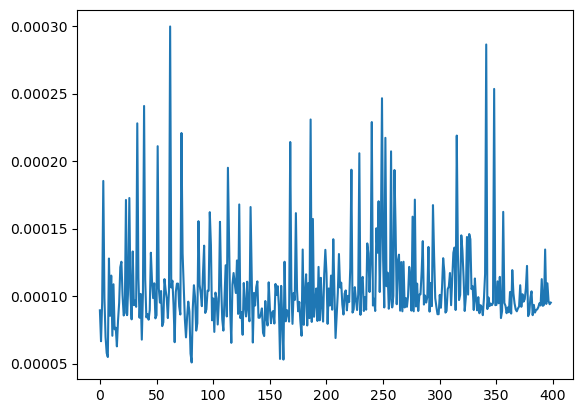

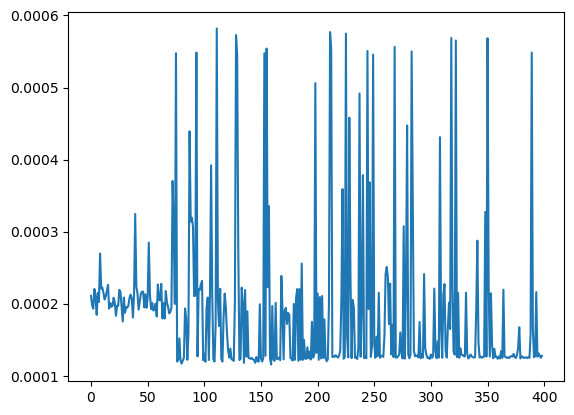

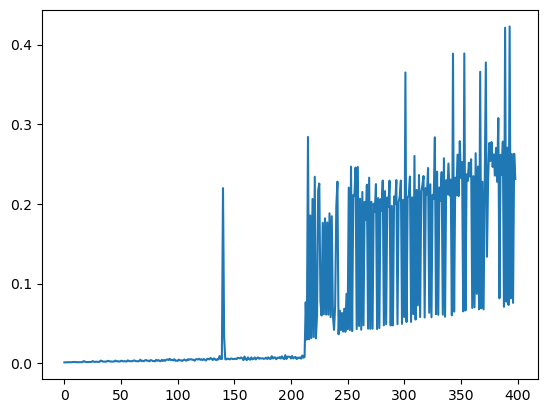

time mesh
33.24985671043396


In [44]:
traj_1 = traj[:400]
print(np.shape(traj_1))
t1mesh = time()
dist_mesh = distances(traj_1)
t2mesh = time()
# t1njit = time()
# dist_njit = distances_njit(traj_1)
# t2njit = time()

print("time mesh")
print(t2mesh-t1mesh)
# print("time njit")
# print(t2njit-t1njit)

(400, 140, 3)


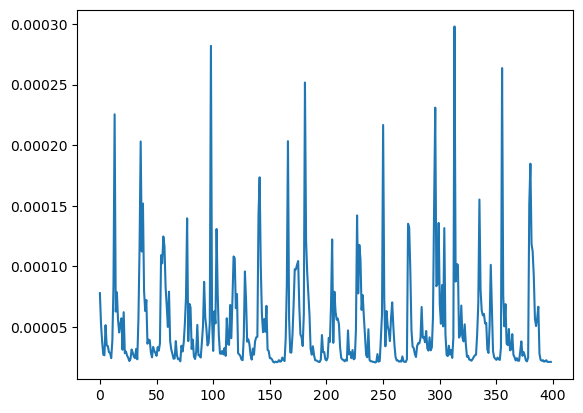

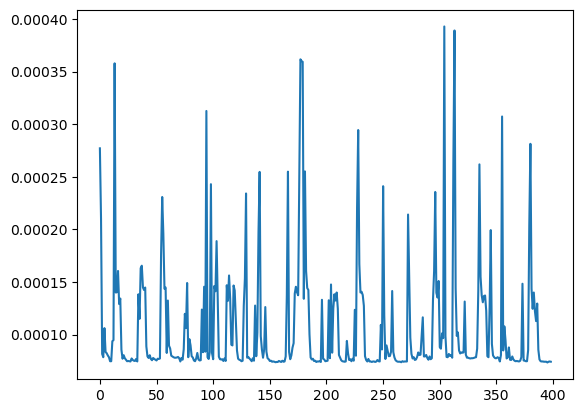

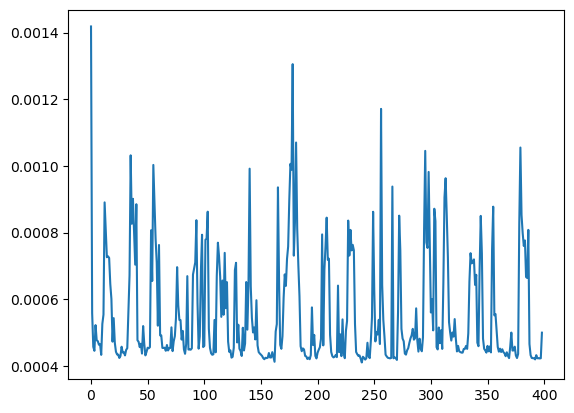

time mesh
1.0021710395812988


In [49]:
traj_1 = traj[:400]
print(np.shape(traj_1))
t1mesh = time()
dist_mesh = distances_2(traj_1)
t2mesh = time()
# t1njit = time()
# dist_njit = distances_njit(traj_1)
# t2njit = time()

print("time mesh")
print(t2mesh-t1mesh)
# print("time njit")
# print(t2njit-t1njit)

In [35]:
# 140 beads
t100 = 0.19
t200 = 0.68
t400 = 19.76
t800 = 

print(np.shape(np.array(dist_mesh)))

(400, 140, 140)


In [4]:
x = np.array(((1, 2),(3,4)))
print(x[0,-1])

2


#### Loop through systems and calculate shit